In [ ]:
!git clone https://github.com/joshuazhou744/vit_paper_replicating.git

Cloning into 'vit_paper_replicating'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 324 (delta 1), reused 324 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (324/324), 16.09 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%%capture
!pip install matplotlib
!pip install tqdm
!pip install requests

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
from vit_paper_replicating.going_modular import data_setup, engine
from vit_paper_replicating.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b0f16335400>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))

INDEX = 0

image, label = image_batch[INDEX], label_batch[INDEX]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

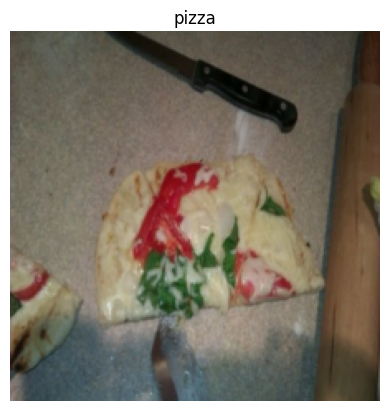

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

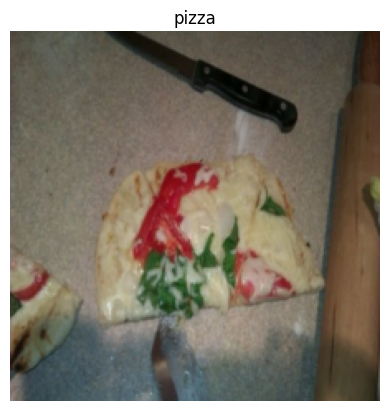

In [ ]:
#visualize full image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

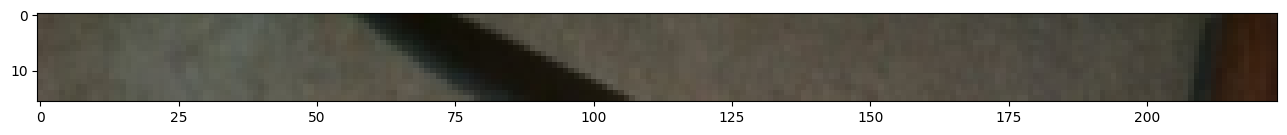

In [ ]:
# visualize top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


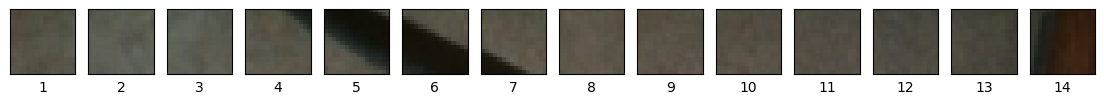

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


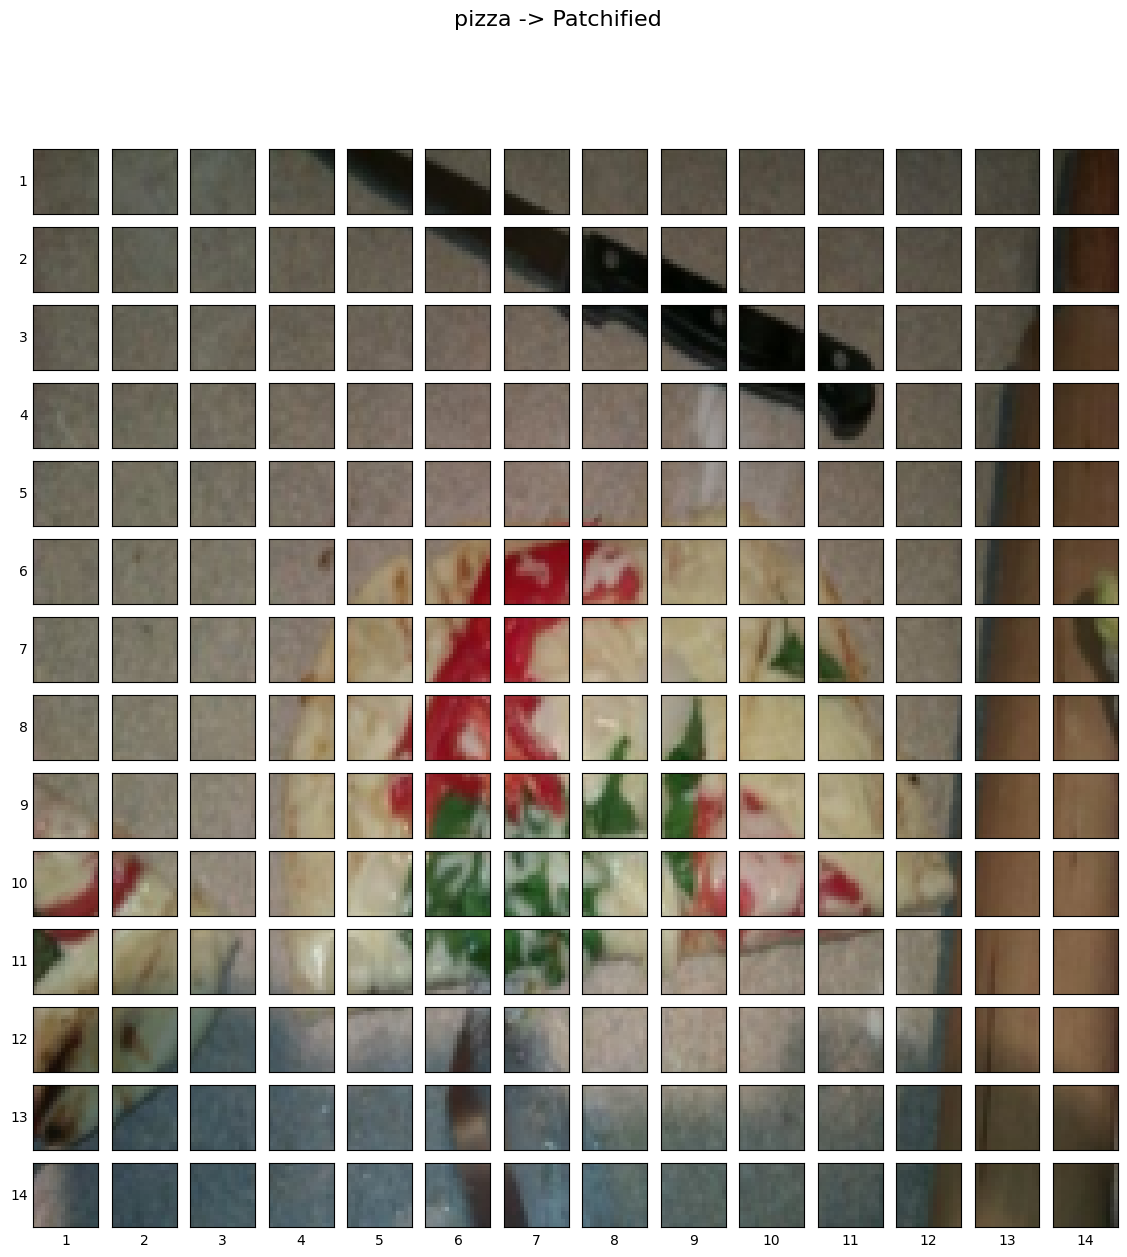

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [ ]:
from torch import nn

# set patch size
patch_size = 16

# create the conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

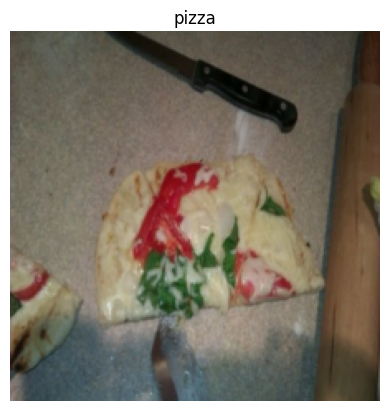

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [ ]:
# pass the image through the convolutional layer
# .unsqueeze(0) adds a dimension to the front
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape) # project from image (B, C, H, W) -> (B, embedding dimension, patch size, patch size)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [281, 421, 599, 199, 29]


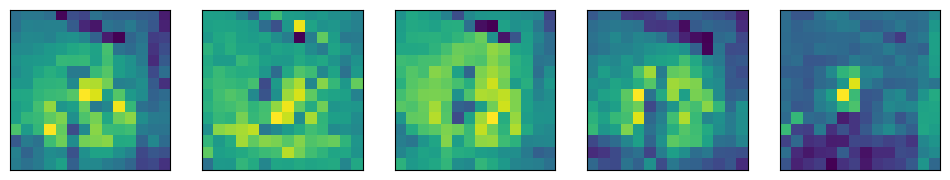

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

# each plot shows ONE convolutional filter in the layer, e.g., edges, textures, etc.

In [ ]:
# get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad # the tensor and whether or not it's learnable

(tensor([[[-9.0127e-02, -1.2341e-01, -1.0999e-01, -9.0544e-02, -1.8713e-01,
           -7.3226e-02, -4.8171e-02, -9.5892e-02, -1.0682e-01, -8.6832e-02,
           -1.0149e-01, -9.8097e-02, -9.7794e-02, -4.4190e-02],
          [-9.9653e-02, -9.8035e-02, -1.2150e-01, -1.2204e-01, -1.1163e-01,
           -6.5186e-02, -1.5755e-01, -9.8279e-03,  4.9062e-02, -1.0010e-01,
           -9.4708e-02, -1.0449e-01, -9.2143e-02, -3.1617e-02],
          [-9.5462e-02, -1.0910e-01, -1.4003e-01, -1.2251e-01, -1.1277e-01,
           -1.1782e-01, -8.9916e-02, -1.4190e-01, -1.2504e-01, -2.6287e-02,
            1.9700e-02, -9.7970e-02, -1.1096e-01, -3.7656e-02],
          [-1.1647e-01, -1.0928e-01, -1.2202e-01, -1.1635e-01, -1.2553e-01,
           -1.5951e-01, -1.3055e-01, -1.6202e-01, -6.9319e-02, -1.0458e-01,
           -1.4674e-01, -1.0626e-01, -1.0134e-01, -4.9157e-02],
          [-1.2417e-01, -1.2989e-01, -1.5052e-01, -1.4713e-01, -1.5020e-01,
           -1.5198e-01, -1.5763e-01, -1.5601e-01, -1.4826e-0

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# create a flatten layer that flattens dimensions 2 and 3 (batch, channel, height, width)
# we flatten the height/width dimensions to get 196 positions in the image
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


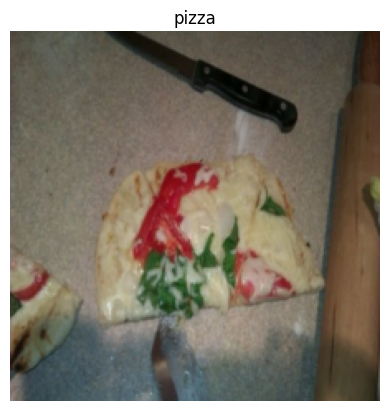

In [ ]:
# view single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [ ]:
# get flattened image patch embeddgins in the right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2*C, N] -> [batch_size, N, P^2*C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

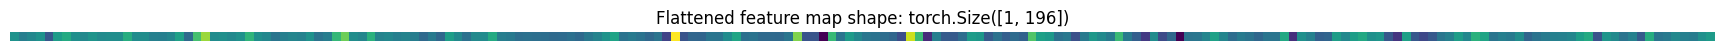

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-9.0127e-02, -1.2341e-01, -1.0999e-01, -9.0544e-02, -1.8713e-01,
          -7.3226e-02, -4.8171e-02, -9.5892e-02, -1.0682e-01, -8.6832e-02,
          -1.0149e-01, -9.8097e-02, -9.7794e-02, -4.4190e-02, -9.9653e-02,
          -9.8035e-02, -1.2150e-01, -1.2204e-01, -1.1163e-01, -6.5186e-02,
          -1.5755e-01, -9.8279e-03,  4.9062e-02, -1.0010e-01, -9.4708e-02,
          -1.0449e-01, -9.2143e-02, -3.1617e-02, -9.5462e-02, -1.0910e-01,
          -1.4003e-01, -1.2251e-01, -1.1277e-01, -1.1782e-01, -8.9916e-02,
          -1.4190e-01, -1.2504e-01, -2.6287e-02,  1.9700e-02, -9.7970e-02,
          -1.1096e-01, -3.7656e-02, -1.1647e-01, -1.0928e-01, -1.2202e-01,
          -1.1635e-01, -1.2553e-01, -1.5951e-01, -1.3055e-01, -1.6202e-01,
          -6.9319e-02, -1.0458e-01, -1.4674e-01, -1.0626e-01, -1.0134e-01,
          -4.9157e-02, -1.2417e-01, -1.2989e-01, -1.5052e-01, -1.4713e-01,
          -1.5020e-01, -1.5198e-01, -1.5763e-01, -1.5601e-01, -1.4826e-01,
          -1.5890e-01, -1

In [ ]:
class PatchEmbedding(nn.Module):
  """
  Turns a 2D input image into a 1D sequence learnable embedding vector

  Args:
    in_channels (int): Number of color channels for the input images, defaults to 3.
    patch_size (int): Size of patches to convert input image into, defaults to 16.
    embedding_size (int): Size of embedding to turn image into, defaults to 768.
  """

  # initialize with appropriate variables
  def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
    super().__init__()
    self.patch_size = patch_size

    # create convolutional layer to turn image into patches
    self.patcher = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0
    )

    # create flatten later to flatten the patch feature maps into a single dimension
    # flatten height and width at indices 2 and 3
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  # forward pass method
  def forward(self, x):
    # create assertion to check that the inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # perform forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # reoarder output shape and return
    return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds()

In [ ]:
# instantiate the patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# pass single image through the layer
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.3625,  0.0826, -0.1179,  ...,  0.2491, -0.1314,  0.1234],
         [-0.3760,  0.0979, -0.1319,  ...,  0.2805, -0.1595,  0.1435],
         [-0.4000,  0.0778, -0.1409,  ...,  0.2875, -0.1585,  0.1446],
         ...,
         [-0.2838,  0.0014, -0.0773,  ...,  0.2162, -0.1525,  0.1160],
         [-0.3027,  0.0510, -0.1190,  ...,  0.1994, -0.1147,  0.1282],
         [-0.2224,  0.0553, -0.0909,  ...,  0.1485, -0.0972,  0.1443]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# get batch size and embedding dimensions
batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]

# create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimensions), requires_grad=True)

# show the first 10 examples of the class_token
print(class_token[:, :, :10])

# print he class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note:** Here we're only creating the class token embedding as [`torch.ones()`](https://pytorch.org/docs/stable/generated/torch.ones.html) for demonstration purposes, in reality, you'd likely create the class token embedding with [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

Notice that the `number_of_tokens` dimension is 1 because we only want to prepend **ONE** class token value to the start of the patch embedding sequence.

In [ ]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

# print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
# should be [1, 197, 768]
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3625,  0.0826, -0.1179,  ...,  0.2491, -0.1314,  0.1234],
         [-0.3760,  0.0979, -0.1319,  ...,  0.2805, -0.1595,  0.1435],
         ...,
         [-0.2838,  0.0014, -0.0773,  ...,  0.2162, -0.1525,  0.1160],
         [-0.3027,  0.0510, -0.1190,  ...,  0.1994, -0.1147,  0.1282],
         [-0.2224,  0.0553, -0.0909,  ...,  0.1485, -0.0972,  0.1443]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3625,  0.0826, -0.1179,  ...,  0.2491, -0.1314,  0.1234],
          [-0.3760,  0.0979, -0.1319,  ...,  0.2805, -0.1595,  0.1435],
          ...,
          [-0.2838,  0.0014, -0.0773,  ...,  0.2162, -0.1525,  0.1160],
          [-0.3027,  0.0510, -0.1190,  ...,  0.1994, -0.1147,  0.1282],
          [-0.2224,  0.0553, -0.0909,  ...,  0.1485, -0.0972,  0.1443]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

which is 197 x 768

Where:
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).

Luckily we've got both of these values already.

So let's make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$.

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

print(number_of_patches, embedding_dimension)

196 768


Every patch embedding gets a position embedding of the same shape.

In [ ]:
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# show first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6375, 1.0826, 0.8821,  ..., 1.2491, 0.8686, 1.1234],
         [0.6240, 1.0979, 0.8681,  ..., 1.2805, 0.8405, 1.1435],
         ...,
         [0.7162, 1.0014, 0.9227,  ..., 1.2162, 0.8475, 1.1160],
         [0.6973, 1.0510, 0.8810,  ..., 1.1994, 0.8853, 1.1282],
         [0.7776, 1.0553, 0.9091,  ..., 1.1485, 0.9028, 1.1443]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do so by:
1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

We'll also make sure to set the random seeds with `set_seeds()` and print out the shapes of different tensors along the way.

In [ ]:
set_seeds()

# 1. set patch size
patch_size = 16

# 2. print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, weight = image.shape[1], image.shape[2]

# 3. get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768,
)

# 5. pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. create position embedding
number_of_patches = int((height * weight) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# 9. add position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, num_heads: int=12, attn_dropout: float=0):
    super().__init__()

    # create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # create the multi-head attention (MSA) layer
    self.multihead_attention = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True,
    )

  # create a forward method to pass data through layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attention(
        query=x, # query embeddings
        key=x, # key embeddings
        value=x, # value embeddings
        need_weights=False # only return output values and not weights
    )
    return attn_output


In [ ]:
mutlihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

patched_image_through_msa_block = mutlihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6375, 1.0826, 0.8821,  ..., 1.2491, 0.8686, 1.1234],
         [0.6240, 1.0979, 0.8681,  ..., 1.2805, 0.8405, 1.1435],
         ...,
         [0.7162, 1.0014, 0.9227,  ..., 1.2162, 0.8475, 1.1160],
         [0.6973, 1.0510, 0.8810,  ..., 1.1994, 0.8853, 1.1282],
         [0.7776, 1.0553, 0.9091,  ..., 1.1485, 0.9028, 1.1443]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2285, -0.2111,  0.0746,  ..., -0.4519,  0.9160, -0.4967],
         [-0.2233, -0.2061,  0.0786,  ..., -0.4502,  0.9213, -0.5040],
         [-0.2230, -0.2064,  0.0785,  ..., -0.4504,  0.9215, -0.5039],
         ...,
         [-0.2238, -0.2061,  0.0780,  ..., -0.4509,  0.9216, -0.5027],
         [-0.2232, -0.2064,  0.0788,  ..., -0.4499,  0.9214, -0.5038],
         [-0.2217, -0.2079,  0.0782,  ..., -0.4487,  0.9218, -0.5054]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0.1):
    super().__init__()

    # create a norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # create the multilayer perception (MLP) layers
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        # second linear layer takes same in_features as out_features of layer above and output back to original embedding_dim
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout),
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               mlp_size: int=3072,
               mlp_dropout: float=0.1,
               attn_dropout: float=0
               ):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=attn_dropout
    )

    self.mlp_block = MLPBlock(
        embedding_dim=embedding_dim,
        mlp_size=mlp_size,
        dropout=mlp_dropout
    )

  def forward(self, x):
    # create residual connection for MSO block by adding the input to the output (output + x)
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()
# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, # hidden size D
    nhead=12, # self attention heads
    dim_feedforward=3072, # mlp size of the dense layer
    dropout=0.1, # dense layer dropout percentage
    activation="gelu", # activation method
    batch_first=True, # first dimension is the batch dimension
    norm_first=True, # normalize first of after MSA/MLP layers
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [ ]:
from types import prepare_class
# 1. create a ViT class
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. initialize the class with hyperparameters
    def __init__(self,
                 img_size:int=224, # training resolution
                 in_channels:int=3, # number of channels in the input image (RGB = 3)
                 patch_size:int=16, # resolution of the patch sizes (16x16 pixels)
                 num_transformer_layers:int=12, # number of transformer encoder blocks/layers
                 embedding_dim:int=768, # vector size/length of each patch embedding
                 mlp_size:int=3072, # hidden layer size in the feedforward network
                 num_heads:int=12, # number of self attention heads
                 attn_dropout:float=0, # dropout for attention projection
                 mlp_dropout:float=0.1, # dropout for dense/feed forward layers
                 embedding_dropout:float=0.1, # dropout for patch and position embeddings
                 num_classes:int=1000, # number of output classes, default 1000 for ImageNet
                 ):
      super().__init__()

      # 3. make sure image size is divisible by the patch size
      assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

      # 4. calculate number of patches = (height*width) / patch^2
      self.num_patches = (img_size**2) // (patch_size**2)

      # 5. create learnable class embedding (prepended to patch embeddings)
      self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

      # 6. create learnable position embedding
      self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

      # 7. create embedding dropout value
      self.embedding_dropout = nn.Dropout(p=embedding_dropout)

      # 8. create patch embedding layer
      self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

      # 9. create transformer encoder blocks (stacked using nn.Sequential)
      self.transformer_encoder = nn.Sequential(
          *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                    num_heads=num_heads,
                                    mlp_size=mlp_size,
                                    mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
      )

      # 10. create classifier head
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim, out_features=num_classes)
      )

    # 11. create forward() method
    def forward(self, x):

      # 12. get batch size
      batch_size = x.shape[0]

      # 13. create class token embedding and expand it to match the batch size
      class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to keep the dimension shape as is

      # 14. create a patch embedding
      x = self.patch_embedding(x)

      # 15. concat the class and patch embedding
      x = torch.cat((class_token, x), dim=1)

      # 16. add position embedding to patch embedding
      x = self.position_embedding + x

      # 17. run embedding dropout
      x = self.embedding_dropout(x)

      # 18. pass patch, position, and class embedding through transformer encoder layers
      x = self.transformer_encoder(x)

      # 19. put 0 index logit through classifier
      x = self.classifier(x[:, 0]) # run on each sample in a batch at index 0

      return x

In [ ]:
# example of creating hte class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [ ]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

## Training

create an optimizer and a loss function

In [ ]:
from vit_paper_replicating.going_modular import engine

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3, # base learning rate from the paper
    betas=(0.9, 0.999),
    weight_decay=0.3
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
set_seeds()

# train model and save the training results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


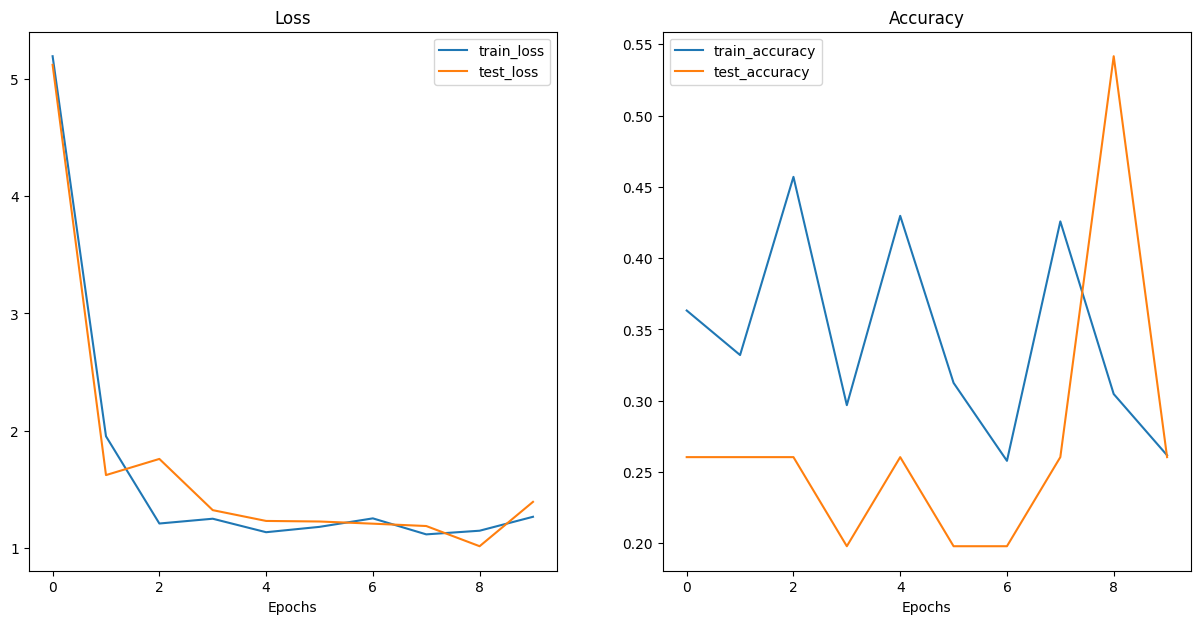

In [ ]:
from vit_paper_replicating.helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup a vit model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freeze base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False


In [ ]:
# current classifier head
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
# change classifier head to ONLY classify our three classes
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
# new classifier head
pretrained_vit.heads

Linear(in_features=768, out_features=3, bias=True)

In [ ]:
# full model
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
from vit_paper_replicating.helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32,
)

In [ ]:
from vit_paper_replicating.going_modular import engine

# create optimizer
optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3,
)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# train classifier head of the pretrained vit feature extractor model
set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


In [ ]:
# check how many parameters can be trained
# should be 2, one for weights of the classifier head and one for bias of the classifier head (linear)
sum(p.requires_grad for p in pretrained_vit.parameters())

2

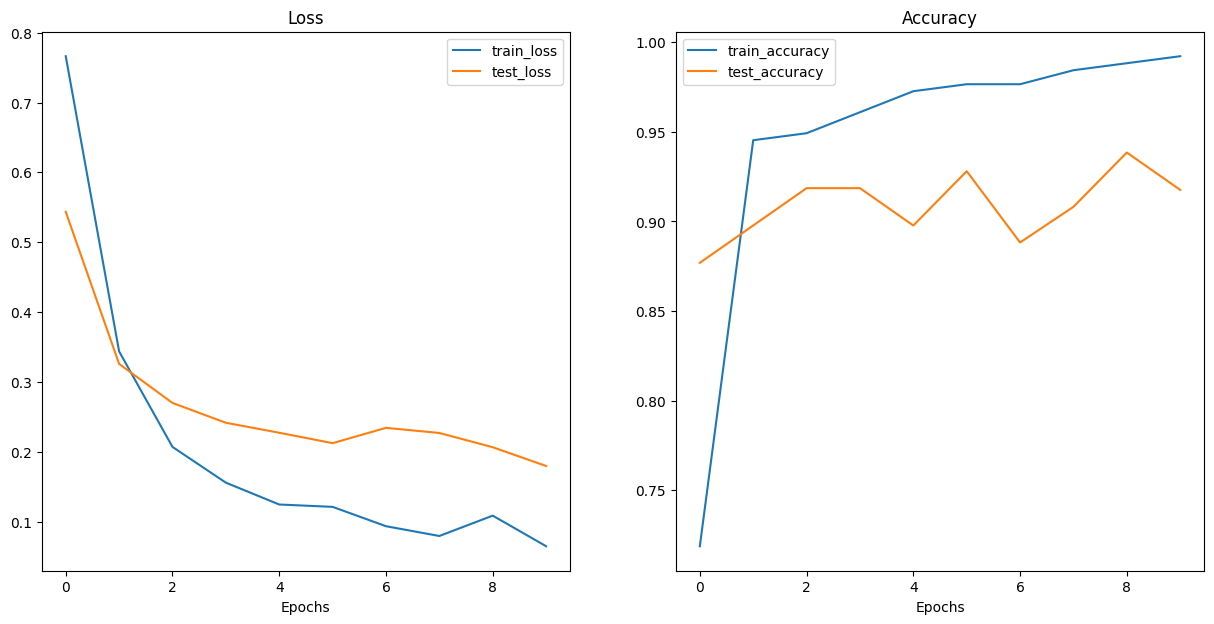

In [ ]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
from vit_paper_replicating.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


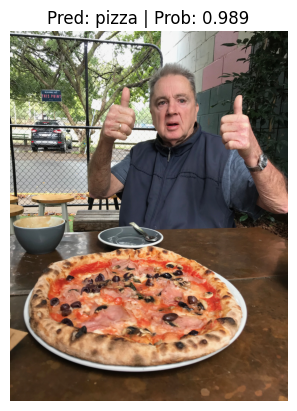

In [ ]:
import requests

# Import function to make predictions on images and plot them
from vit_paper_replicating.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

done